<a href="https://colab.research.google.com/github/sunflowerseed17/PythonDSProject/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Loading

In [124]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from empath import Empath
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from statsmodels.stats.multitest import multipletests
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from collections import defaultdict


import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nataszasiwinska/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataszasiwinska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [125]:
# Base Class
class FeatureExtractor:
    def __init__(self, documents, labels, output_folder="data/feature_extracted_data"):
        self.documents = documents
        self.labels = labels
        self.output_folder = output_folder
        os.makedirs(self.output_folder, exist_ok=True)

    def preprocess_text(self, text):
        """
        Tokenize, lowercase, remove stopwords, and stem.
        """
        stop_words = set(stopwords.words('english'))
        stemmer = PorterStemmer()
        tokens = word_tokenize(text.lower())
        return [stemmer.stem(word) for word in tokens if word.isalpha() and word not in stop_words]

    def save_to_csv(self, data, filename):
        """
        Save data to a CSV file.
        """
        # Construct the full file path
        if not filename.startswith(self.output_folder):
            file_path = os.path.join(self.output_folder, filename)
        else:
            file_path = filename

        # Debugging: Print the path being used
        print(f"Saving file to: {file_path}")

        # Ensure the directory exists
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Save the file if it doesn't already exist
        if not os.path.exists(file_path):
            data.to_csv(file_path, index=False)
            print(f"Saved to {file_path}.")
        else:
            print(f"File already exists at {file_path}.")

In [126]:
# N-Gram Feature Extractor
class NGramFeatureExtractor(FeatureExtractor):
    def __init__(self, documents, labels, output_folder="data/feature_extracted_data"):
        super().__init__(documents, labels, output_folder)
        self.vectorizer_unigram = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
        self.vectorizer_bigram = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
        self.vectorizer_combined = TfidfVectorizer(ngram_range=(1, 2), stop_words='english') 
        self.unigram_matrix = None
        self.bigram_matrix = None
        self.unigram_feature_names = None
        self.bigram_feature_names = None
        self.combined_matrix = None
        self.combined_feature_names = None

        os.makedirs(self.output_folder, exist_ok=True)

    def extract_features(self):
        """
        Extract unigram and bigram features using TF-IDF.
        """
        print("Extracting unigrams...")
        self.unigram_matrix = self.vectorizer_unigram.fit_transform(self.documents)
        self.unigram_feature_names = self.vectorizer_unigram.get_feature_names_out()
        print(f"Number of unigram features: {len(self.unigram_feature_names)}")

        print("Extracting bigrams...")
        self.bigram_matrix = self.vectorizer_bigram.fit_transform(self.documents)
        self.bigram_feature_names = self.vectorizer_bigram.get_feature_names_out()
        print(f"Number of bigram features: {len(self.bigram_feature_names)}")

        print("Extracting combined unigrams and bigrams...")
        self.combined_matrix = self.vectorizer_combined.fit_transform(self.documents)
        self.combined_feature_names = self.vectorizer_combined.get_feature_names_out()
        print(f"Number of combined unigram and bigram features: {len(self.combined_feature_names)}")

        return self.unigram_matrix, self.bigram_matrix, self.combined_matrix
    
    def save_features(self):
        """
        Save unigram and bigram features with labels as CSV files.
        """
        unigram_file = os.path.join(self.output_folder, "unigram_features_with_labels.csv")
        bigram_file = os.path.join(self.output_folder, "bigram_features_with_labels.csv")

        if not os.path.exists(unigram_file):
            unigram_df = pd.DataFrame(self.unigram_matrix.toarray(), columns=self.unigram_feature_names)
            unigram_df['label'] = self.labels
            unigram_df.to_csv(unigram_file, index=False)
            print(f"Saved unigram features to {unigram_file}.")
        else:
            print(f"Unigram features file already exists at {unigram_file}.")

        if not os.path.exists(bigram_file):
            bigram_df = pd.DataFrame(self.bigram_matrix.toarray(), columns=self.bigram_feature_names)
            bigram_df['label'] = self.labels
            bigram_df.to_csv(bigram_file, index=False)
            print(f"Saved bigram features to {bigram_file}.")
        else:
            print(f"Bigram features file already exists at {bigram_file}.")

    def get_top_features(self, feature_type="unigram", top_n=10):
        """
        Get the top N most common features for unigrams or bigrams based on TF-IDF scores.
        """
        if feature_type == "unigram":
            tfidf_sums = np.array(self.unigram_matrix.sum(axis=0)).flatten()
            feature_names = self.unigram_feature_names
        elif feature_type == "bigram":
            tfidf_sums = np.array(self.bigram_matrix.sum(axis=0)).flatten()
            feature_names = self.bigram_feature_names
        else:
            raise ValueError("Invalid feature_type. Choose 'unigram' or 'bigram'.")

        top_indices = np.argsort(tfidf_sums)[-top_n:]
        print(f"Top {top_n} Most Common {feature_type.capitalize()} Features:")
        for i in reversed(top_indices):
            print(f"{feature_names[i]}: {tfidf_sums[i]:.4f}")

    def train_model(self, feature_type="unigram"):
        """
        Train a Logistic Regression model using unigrams or bigrams.
        """
        if feature_type == "unigram":
            X = self.unigram_matrix
        elif feature_type == "bigram":
            X = self.bigram_matrix
        else:
            raise ValueError("Invalid feature_type. Choose 'unigram' or 'bigram'.")

        X_train, X_test, y_train, y_test = train_test_split(X, self.labels, test_size=0.2, random_state=42)
        print(f"Training set size: {X_train.shape}")
        print(f"Testing set size: {X_test.shape}")

        param_grid = {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['liblinear']
        }
        grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        print("\nBest Hyperparameters:")
        print(grid_search.best_params_)

        classifier = grid_search.best_estimator_
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

        return classifier

    def visualize_wordcloud(self, feature_type="unigram", max_words=100, title="Word Cloud"):
        """
        Generate a word cloud for unigrams or bigrams or combined with a specific label.
        """
            # Select the appropriate matrix and feature names
        if feature_type == "unigram":
            matrix = self.unigram_matrix
            feature_names = self.unigram_feature_names
            title = "Unigram Word Cloud"
        elif feature_type == "bigram":
            matrix = self.bigram_matrix
            feature_names = self.bigram_feature_names
            title = "Bigram Word Cloud"
        elif feature_type == "combined":
            if not hasattr(self, "combined_matrix") or not hasattr(self, "combined_feature_names"):
                raise ValueError("Combined features must be extracted before generating a word cloud.")
            matrix = self.combined_matrix
            feature_names = self.combined_feature_names
            title = "Combined Unigram and Bigram Word Cloud"
        else:
            raise ValueError("Invalid feature_type. Choose 'unigram', 'bigram', or 'combined'.")

        # Sum TF-IDF scores across all documents
        tfidf_sums = np.array(matrix.sum(axis=0)).flatten()

        # Create a dictionary mapping feature names to their TF-IDF scores
        word_scores = {feature_names[i]: tfidf_sums[i] for i in range(len(feature_names))}
    
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words)
        wordcloud = wordcloud.generate_from_frequencies(word_scores)
    
        # Display the word cloud
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=16)
        plt.show()

In [127]:
# Empath Feature Extractor
class EmpathFeatureExtractor(FeatureExtractor):
    def __init__(self, documents, labels, selected_categories, output_folder="data/feature_extracted_data"):
        """
        Initialize the EmpathFeatureExtractor class.

        Parameters:
        documents (list of str): List of documents to analyze.
        labels (list of int): Labels corresponding to the documents.
        selected_categories (dict): Categories for Empath analysis.
        output_folder (str): Folder to save the results.
        """
        super().__init__(documents, labels, output_folder)
        self.lexicon = Empath()
        self.categories = selected_categories
        self.features = None
        self.correlation_results = None
        self.significant_results = None

    def extract_empath_features(self):
        """
        Extract Empath features based on the selected categories.
        """
        features = []
        for doc in self.documents:
            doc_features = {}

            # Linguistic features
            for category in self.categories["linguistic_features"]:
                doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            # Psychological processes
            for subcategory, categories in self.categories["psychological_processes"].items():
                for category in categories:
                    doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            # Personal concerns
            for category in self.categories["personal_concerns"]:
                doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            # Time orientations
            for category in self.categories["time_orientations"]:
                doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            features.append(doc_features)

        # Convert to a DataFrame
        self.features = pd.DataFrame(features)
        print(f"Extracted Empath features with shape: {self.features.shape}")

    def analyze_correlation(self):
        """
        Analyze correlations between extracted features and labels.
        """
        if self.features is None:
            raise ValueError("Features must be extracted before analyzing correlations.")

        # Remove constant columns
        constant_columns = self.features.columns[self.features.nunique() == 1]
        self.features = self.features.drop(columns=constant_columns)
        print(f"Removed constant columns: {constant_columns.tolist()}")

        # Validate labels
        if len(set(self.labels)) == 1:
            raise ValueError("Labels array is constant; cannot compute correlation.")

        correlations, p_values = [], []

        for column in self.features.columns:
            try:
                # Calculate Pearson correlation and p-value
                correlation, p_value = pearsonr(self.features[column], self.labels)
                correlations.append(correlation)
                p_values.append(p_value)
            except ValueError as e:
                print(f"Skipping feature {column} due to constant input.")
                correlations.append(None)
                p_values.append(None)

        # Apply Benjamini-Hochberg correction
        correction_results = multipletests(p_values, alpha=0.05, method="fdr_bh")
        _, corrected_p_values, _, _ = correction_results

        # Create correlation results DataFrame
        self.correlation_results = pd.DataFrame({
            "Feature": self.features.columns,
            "Correlation": correlations,
            "P-Value": p_values,
            "Corrected P-Value": corrected_p_values
        }).sort_values(by="Correlation", key=abs, ascending=False)

    def filter_significant_results(self):
        """
        Filter significant results based on corrected P-values.
        """
        if self.correlation_results is None:
            raise ValueError("Correlation analysis must be performed before filtering significant results.")

        def significance_stars(p):
            if p < 0.001:
                return '***'
            elif p < 0.01:
                return '**'
            elif p < 0.05:
                return '*'
            return ''  # No significance

        self.correlation_results["Significance"] = self.correlation_results["Corrected P-Value"].apply(significance_stars)
        self.significant_results = self.correlation_results[self.correlation_results["Significance"] != '']

    def map_features_to_categories(self):
        """
        Map significant features to their respective categories.
        """
        if self.significant_results is None:
            raise ValueError("Significant results must be filtered before mapping features to categories.")

        def map_features(features, categories):
            grouped_results = {}
            for feature in features:
                for category, subcategories in categories.items():
                    if isinstance(subcategories, list):  # Flat category
                        if feature in subcategories:
                            grouped_results.setdefault(category, []).append(feature)
                    elif isinstance(subcategories, dict):  # Nested subcategories
                        for subcategory, sub_features in subcategories.items():
                            if feature in sub_features:
                                grouped_results.setdefault(f"{category} - {subcategory}", []).append(feature)
            return grouped_results

        grouped_results = map_features(self.significant_results["Feature"], self.categories)
        print("Mapped features to categories.")

        formatted_results = [
            {
                "Category": category,
                "Feature": feature,
                "Correlation": self.significant_results.loc[self.significant_results["Feature"] == feature, "Correlation"].values[0],
                "P-Value": self.significant_results.loc[self.significant_results["Feature"] == feature, "P-Value"].values[0],
                "Significance": self.significant_results.loc[self.significant_results["Feature"] == feature, "Significance"].values[0],
            }
            for category, features in grouped_results.items()
            for feature in features
        ]
        return pd.DataFrame(formatted_results).sort_values(by=["Category", "Correlation"], ascending=[True, False])

    def save_features_and_results(self):
        """
        Save extracted features and correlation results to CSV files.
        """
        # Save features
        feature_file = "empath_features_with_labels.csv"
        full_feature_path = os.path.join(self.output_folder, feature_file)
        if not os.path.exists(full_feature_path):
            self.features["label"] = self.labels
            self.save_to_csv(self.features, full_feature_path)
        else:
            print(f"Feature file already exists at {full_feature_path}.")

        # Save correlation results
        if self.correlation_results is not None:
            correlation_file = "empath_correlation_results.csv"
            full_correlation_path = os.path.join(self.output_folder, correlation_file)
            if not os.path.exists(full_correlation_path):
                self.save_to_csv(self.correlation_results, full_correlation_path)
            else:
                print(f"Correlation file already exists at {full_correlation_path}.")

    



In [128]:
# LDA Feature Extractor
class LDAFeatureExtractor(FeatureExtractor):
    def __init__(self, documents, labels, num_topics=30, passes=15, output_folder="data/feature_extracted_data", random_state=42):
        super().__init__(documents, labels, output_folder)
        self.num_topics = num_topics
        self.passes = passes
        self.random_state = random_state
        self.dictionary = None
        self.corpus = None
        self.lda_model = None
        self.topic_distributions = None
        self.tsne_results = None

    def preprocess_documents(self):
        """
        Preprocess documents: tokenize, remove stopwords, and stem.
        """
        stop_words = set(stopwords.words('english'))
        stemmer = PorterStemmer()
        processed_docs = [
            [
                stemmer.stem(word) for word in word_tokenize(doc.lower())
                if word.isalpha() and word not in stop_words
            ]
            for doc in self.documents
        ]
        return processed_docs

    def filter_docs_by_word_count(self, processed_docs, min_documents=10):
        """
        Filter words that appear in more than 10 documents.
        """
        word_doc_count = defaultdict(int)
        for doc in processed_docs:
            unique_words = set(doc)
            for word in unique_words:
                word_doc_count[word] += 1

        filtered_docs = [
            [word for word in doc if word_doc_count[word] > min_documents]
            for doc in processed_docs
        ]
        return filtered_docs

    def train_lda(self, processed_docs):
        """
        Train the LDA model.
        """
        self.dictionary = corpora.Dictionary(processed_docs)
        self.corpus = [self.dictionary.doc2bow(doc) for doc in processed_docs]
        self.lda_model = LdaModel(
            self.corpus, num_topics=self.num_topics, id2word=self.dictionary, passes=self.passes,
            random_state=self.random_state
        )

    def extract_topic_distributions(self):
        """
        Extract topic distributions for each document.
        """
        self.topic_distributions = [
            dict(self.lda_model.get_document_topics(doc, minimum_probability=0))
            for doc in self.corpus
        ]

    def topic_distribution_to_matrix(self):
        """
        Convert topic distributions to a matrix format.
        """
        matrix = np.zeros((len(self.topic_distributions), self.num_topics))
        for i, distribution in enumerate(self.topic_distributions):
            for topic_id, prob in distribution.items():
                matrix[i, topic_id] = prob
        return matrix

    def visualize_lda(self, label_filter=None):
        """
        Visualize the LDA model with pyLDAvis, with an option to filter by depressed or non-depressed posts.

        Parameters:
        label_filter (int, optional): Filter by label. Use 1 for depressed, 0 for non-depressed. 
                                       If None, visualize all posts.
        """
        if not self.lda_model or not self.dictionary:
            raise ValueError("LDA model or dictionary not available. Train the model first.")
        
        # Filtered visualization
        if label_filter is not None:
            filtered_docs = [doc for doc, label in zip(self.documents, self.labels) if label == label_filter]
            print(f"Generating LDA visualization for {'depressed' if label_filter == 1 else 'non-depressed'} posts...")

            # Preprocess the filtered documents
            stop_words = set(stopwords.words('english'))
            stemmer = PorterStemmer()
            processed_docs = [
                [
                    stemmer.stem(word) for word in word_tokenize(doc.lower())
                    if word.isalpha() and word not in stop_words
                ]
                for doc in filtered_docs
            ]
            
            # Create a corpus for the filtered documents
            filtered_corpus = [self.dictionary.doc2bow(doc) for doc in processed_docs]
            vis = gensimvis.prepare(self.lda_model, filtered_corpus, self.dictionary)
        else:
            # Visualization for all posts
            print("Generating LDA visualization for all posts...")
            vis = gensimvis.prepare(self.lda_model, self.corpus, self.dictionary)

        # Ensure pyLDAvis works in the notebook
        pyLDAvis.enable_notebook()  # Enable visualization in Jupyter Notebook

        # Display visualization
        return pyLDAvis.display(vis)

    def visualize_tsne(self, matrix):
        """
        Visualize topic distributions using t-SNE.
        """
        labels = self.labels
        tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=self.random_state)
        self.tsne_results = tsne.fit_transform(matrix)

        # Plot
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(
            self.tsne_results[:, 0], self.tsne_results[:, 1], c=labels, cmap='viridis', s=10, alpha=0.7
        )
        plt.legend(handles=scatter.legend_elements()[0], labels=["Non-Depressed", "Depressed"], title="Labels")
        plt.title("t-SNE Visualization of LDA Topic Distributions")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.show()

    def save_features(self):
        """
        Save LDA topic distributions with labels to a CSV file.
        """
        if not self.topic_distributions:
            raise ValueError("Topic distributions are not extracted.")

        # Prepare the LDA features data
        topic_matrix = self.topic_distribution_to_matrix()
        labels_array = np.array(self.labels)
        lda_features_df = pd.DataFrame(topic_matrix)
        lda_features_df['label'] = labels_array

        # Define the filename
        lda_features_file = "lda_topic_distributions_with_labels.csv"

        # Call the base class method for saving
        self.save_to_csv(lda_features_df, lda_features_file)
        
    def run_pipeline(self):
        """
        Complete LDA pipeline: preprocess, train, extract, visualize, and save.
        """
        print("Preprocessing documents...")
        processed_docs = self.preprocess_documents()
        filtered_docs = self.filter_docs_by_word_count(processed_docs)

        print("Training LDA model...")
        self.train_lda(filtered_docs)

        print("Extracting topic distributions...")
        self.extract_topic_distributions()

        print("Saving features...")
        self.save_features()

        print("Visualizing t-SNE...")
        topic_matrix = self.topic_distribution_to_matrix()
        self.visualize_tsne(topic_matrix)

        print("LDA pipeline complete.")

In [129]:
# Loading data
if __name__ == "__main__":
    # Load documents and labels
    folders = {
        "depression": {"path": "data/preprocessed/preprocessed_depression_posts", "label": 1},
        "breastcancer": {"path": "data/preprocessed/preprocessed_breastcancer_posts", "label": 0},
    }
    documents, labels = [], []
    for category, data in folders.items():
        for file_name in os.listdir(data["path"]):
            file_path = os.path.join(data["path"], file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                documents.append(file.read())
                labels.append(data["label"])
    print(f"Loaded {len(documents)} documents.")
    print(f"Labels: {set(labels)}")


Loaded 293 documents.
Labels: {0, 1}


# N-Gram Extraction

Extracting unigrams...
Number of unigram features: 4296
Extracting bigrams...
Number of bigram features: 29708
Extracting combined unigrams and bigrams...
Number of combined unigram and bigram features: 34004
Saved unigram features to data/feature_extracted_data/unigram_features_with_labels.csv.
Saved bigram features to data/feature_extracted_data/bigram_features_with_labels.csv.

Top Unigram Features:
Top 10 Most Common Unigram Features:
feel: 19.7904
like: 17.1393
want: 13.3932
know: 12.1230
year: 11.2671
life: 10.9066
time: 10.2350
realli: 9.5660
thing: 8.9140
friend: 8.8003

Top Bigram Features:
Top 10 Most Common Bigram Features:
feel like: 7.1419
year old: 1.9008
mental health: 1.7841
anyon els: 1.7453
wan na: 1.6263
lymph node: 1.6214
year ago: 1.5248
everi day: 1.5186
gon na: 1.4851
realli want: 1.3432

Training a model with unigram features...
Training set size: (234, 4296)
Testing set size: (59, 4296)

Best Hyperparameters:
{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}



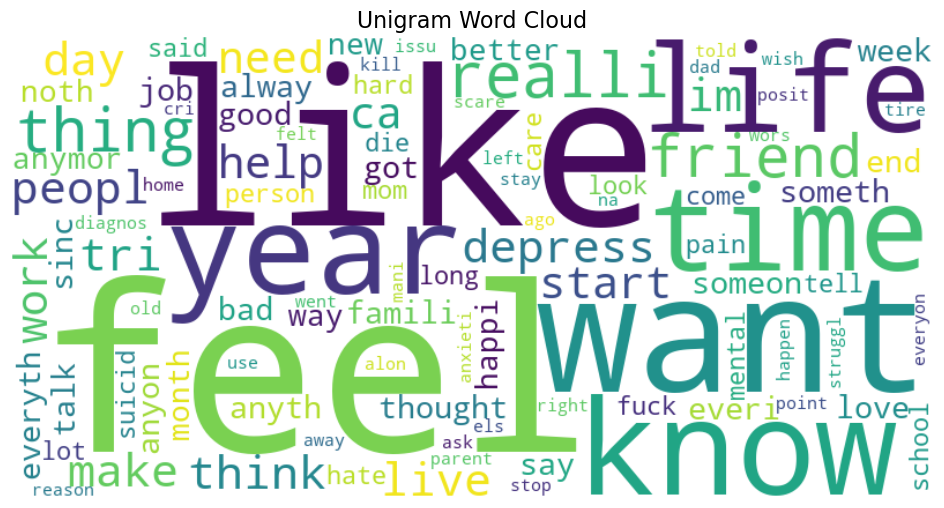

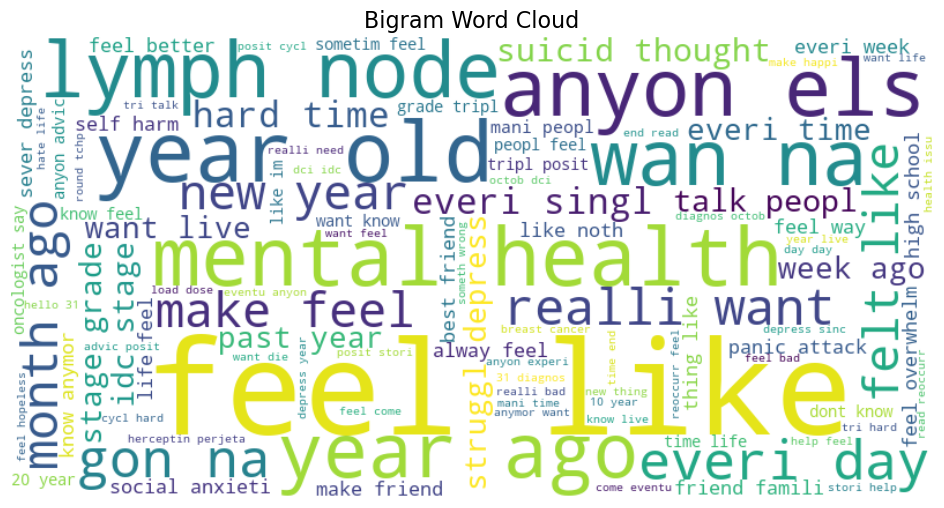

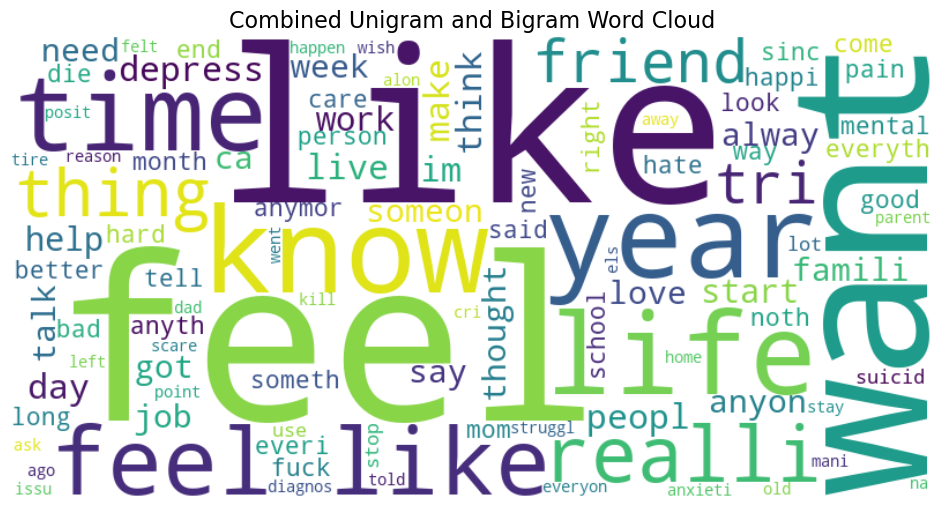

In [130]:
# Initialize, extract, save, analyze, train and generate word clouds.
# Initialize the n-gram extractor
ngram_extractor = NGramFeatureExtractor(documents, labels)

# Extract features
ngram_extractor.extract_features()

# Save features
ngram_extractor.save_features()

# Analyze top features
print("\nTop Unigram Features:")
ngram_extractor.get_top_features(feature_type="unigram", top_n=10)
print("\nTop Bigram Features:")
ngram_extractor.get_top_features(feature_type="bigram", top_n=10)


# Train a model
print("\nTraining a model with unigram features...")
classifier = ngram_extractor.train_model(feature_type="unigram")

# Generate word clouds
print("\nGenerating Word Clouds...")
ngram_extractor.visualize_wordcloud(feature_type="unigram", title="Depression Word Cloud")
ngram_extractor.visualize_wordcloud(feature_type="bigram", title="Non-Depression Word Cloud")
ngram_extractor.visualize_wordcloud(feature_type="combined", title="Combined Word Cloud")

### Extract TF-IDF features, train a logistic regression model with hyperparameter tuning, and identify key features for each category.

Number of valid documents: 293
Sample document (label 1): well quit sure begin text realiti unsur anyth brazilian matter reader feel though die insid noth make sens anymor peopl claim highli intellig liar impostor syndrom might make assert seem bias noth foolish young individu gradual destroy metaphys mental navig life faith anyth incap forc use cheer altruist child often refer angel howev seri event cast abyss bottom pit discov trapdoor lead endlessli deep fall devoid prospect return tri good even know good mean truli exist unattract overweight frequent plagu allergi give perpetu sickli appear amount fit train ever succeed boost tri thing shatter refus numb cultur opiat modern though often think life within plato cave might prefer life devoid thought seem sweeter yet stop think sinc grandmoth pass 2022 everyth unravel unsur whether life lost purpos mean signific simpli thing made joy someon love care know continu live neither wish die find place social believ unpleas other claim oppos

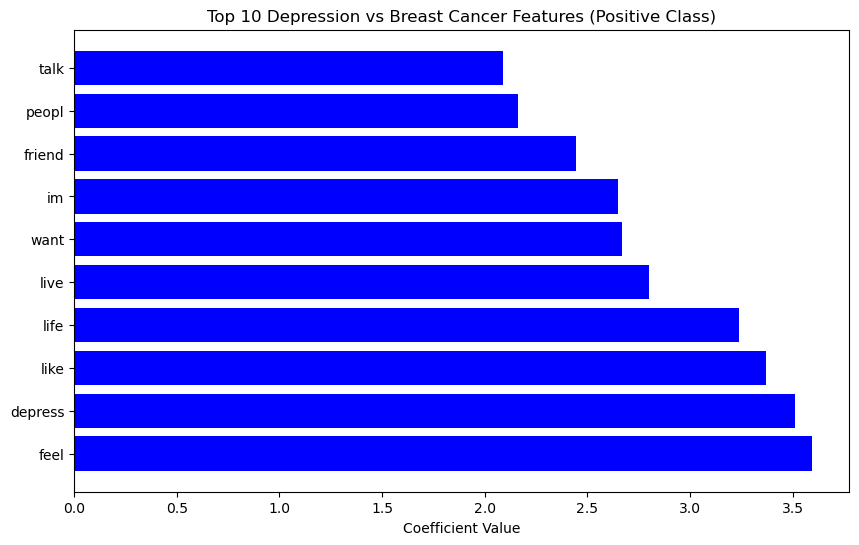

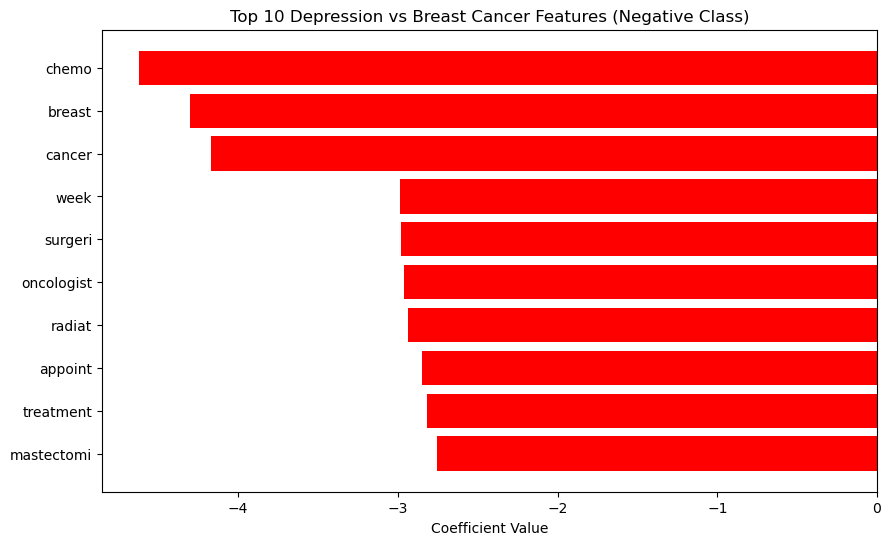

In [131]:

# Debugging: Check documents and labels
print(f"Number of valid documents: {len(documents)}")
if documents:
    print(f"Sample document (label {labels[0]}): {documents[0]}")

# Initialize TfidfVectorizer with unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documents)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L1 is not supported by LogisticRegression with liblinear solver
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:")
print(grid_search.best_params_)

# Train the best Logistic Regression model
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]  # No need to call .toarray() since coef_ is already a numpy array

# Get top 10 positive and negative features
top_positive_indices = np.argsort(coefficients)[-10:]  # Largest coefficients
top_negative_indices = np.argsort(coefficients)[:10]   # Smallest coefficients

print("\nTop 10 Positive Features (indicating depression):")
for i in reversed(top_positive_indices):
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

print("\nTop 10 Negative Features (indicating breast cancer):")
for i in top_negative_indices:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")





def visualize_features(feature_names, coefficients, title, top_n=10):
    sorted_indices = np.argsort(coefficients)
    top_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[-top_n:]]
    bottom_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[:top_n]]
    
    top_features.reverse()  # Largest first
    bottom_features.reverse()  # Smallest first
    
    # Plot positive features
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in top_features], [f[1] for f in top_features], color='blue')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} {title} Features (Positive Class)")
    plt.show()
    
    # Plot negative features
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in bottom_features], [f[1] for f in bottom_features], color='red')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} {title} Features (Negative Class)")
    plt.show()

visualize_features(feature_names, coefficients, "Depression vs Breast Cancer", top_n=10)

# Empath Extraction

In [132]:
# Categories to focus on based on the origin paper. 
# The categories are divided into linguistic features, psychological processes, personal concerns, and time orientations.
# Since we cannot use the LIWC tool, we will use the Empath tool and define similar categorical features. 

selected_categories = {
    "linguistic_features": [
        "articles", "auxiliary_verbs", "adverbs", "conjunctions", 
        "personal_pronouns", "impersonal_pronouns", "negations", 
        "prepositions", "verbs", "nouns", "adjectives", 
        "comparatives", "superlatives", "modifiers", "function_words", 
        "filler_words", "verb_tense", "slang", "jargon", 
        "formal_language", "casual_language", "exclamations", 
        "contractions", "word_complexity", "sentiment_words"
    ],
        "psychological_processes": {
        "affective": [
            "positive_emotion", "negative_emotion", "joy", "anger", 
            "sadness", "anxiety", "fear", "disgust", "love", 
            "hope", "trust", "excitement", "anticipation", 
            "relief", "sympathy", "gratitude", "shame", 
            "guilt", "envy", "pride", "contentment", "confusion",
            "boredom", "embarrassment", "longing", "nostalgia", 
            "embarrassment", "frustration", "surprise", "melancholy"
        ],
        "biological": [
            "body", "health", "illness", "pain", "hygiene", 
            "fitness", "exercise", "nutrition", "ingestion", 
            "physical_state", "medicine", "sleep", "sexual", 
            "aging", "disease", "injury", "hospital", "recovery", 
            "dieting", "mental_health", "drug_use", "headache", 
            "fatigue", "hormones", "appetite"
        ],
        "social": [
            "family", "friends", "relationships", "group_behavior", 
            "teamwork", "social_media", "communication", "community", 
            "peer_pressure", "leadership", "parenting", "mentorship", 
            "marriage", "divorce", "gender_roles", "social_identity", 
            "cultural_rituals", "networking", "altruism", "conflict", 
            "social_support", "dominance", "affiliation", "intimacy", 
            "supportiveness", "competition", "conflict_resolution", 
            "collaboration", "in-group", "out-group", "prejudice"
        ],
        "cognitive": [
            "certainty", "doubt", "insight", "cause", "discrepancy", 
            "problem_solving", "creativity", "self_reflection", "planning", 
            "memory", "perception", "attention", "reasoning", "thought_process", 
            "decision_making", "confusion", "learning", "metacognition", "adaptability", 
            "focus", "perspective", "problem_analysis", "evaluation", "interpretation",
            "logic", "intelligence", "rational_thought", "intuition", "conceptualization"
        ],
        "drives": [
            "achievement", "dominance", "affiliation", "control", 
            "self-esteem", "autonomy", "self-assertion", "power", 
            "ambition", "conformity", "subordination", "dependence", 
            "submission", "accomplishment", "independence", "order", 
            "control_seeking", "status", "prosocial_behavior"
        ],
        "spiritual": [
            "spirituality", "faith", "beliefs", "sacred", "religion", 
            "prayer", "meditation", "afterlife", "soul", "divine", 
            "god", "higher_power", "inspiration", "transcendence", 
            "morality", "ethics", "rituals", "holiness", "mindfulness"
        ]
    },
    "personal_concerns": [
        "work", "money", "wealth", "shopping", "career", "travel", 
        "home", "school", "education", "violence", "death", 
        "retirement", "spirituality", "family_life", "hobbies", 
        "volunteering", "pets", "entertainment", "parenting", 
        "sports", "adventure", "politics", "environment", 
        "safety", "technology", "materialism", "status", 
        "self_improvement", "learning", "self_growth", "happiness", 
        "life_purpose", "work_life_balance", "stress", "coping", 
        "job_satisfaction", "ambition", "legacy", "job_search", 
        "unemployment", "retirement_plans", "mental_health", "dating", 
        "romantic_relationships", "divorce", "life_stressors", "transitions"
    ],
    "time_orientations": [
        "present", "past", "future", "morning", 
        "afternoon", "evening", "day", "night", 
        "weekdays", "weekends", "seasons", "holidays", 
        "lifespan", "long_term", "short_term", 
        "routine", "historical", "epoch", "momentary", 
        "timeliness", "timelessness", "urgency", 
        "progression", "nostalgia", "anticipation"
    ]
}

In [133]:
# Initialize Empath Feature Extractor
empath_extractor = EmpathFeatureExtractor(documents, labels, selected_categories)

# Extract features
empath_extractor.extract_empath_features()

# Analyze correlations
empath_extractor.analyze_correlation()

# Filter significant results
empath_extractor.filter_significant_results()

# Map features to categories
formatted_results = empath_extractor.map_features_to_categories()
print(formatted_results)

# Save features and results
empath_extractor.save_features_and_results()

Extracted Empath features with shape: (293, 237)
Removed constant columns: ['articles', 'auxiliary_verbs', 'adverbs', 'conjunctions', 'personal_pronouns', 'impersonal_pronouns', 'negations', 'prepositions', 'verbs', 'nouns', 'adjectives', 'comparatives', 'superlatives', 'modifiers', 'function_words', 'filler_words', 'verb_tense', 'slang', 'jargon', 'formal_language', 'casual_language', 'exclamations', 'contractions', 'word_complexity', 'sentiment_words', 'anxiety', 'hope', 'excitement', 'relief', 'gratitude', 'guilt', 'boredom', 'embarrassment', 'longing', 'nostalgia', 'frustration', 'melancholy', 'illness', 'fitness', 'nutrition', 'ingestion', 'physical_state', 'medicine', 'aging', 'disease', 'hospital', 'recovery', 'dieting', 'mental_health', 'drug_use', 'headache', 'fatigue', 'hormones', 'appetite', 'relationships', 'group_behavior', 'teamwork', 'community', 'peer_pressure', 'leadership', 'parenting', 'mentorship', 'marriage', 'divorce', 'gender_roles', 'social_identity', 'cultural_

# LDA (Latent Dirichlet Allocation) Extraction

Preprocessing documents...
Training LDA model...
Extracting topic distributions...
Saving features...
Saving file to: data/feature_extracted_data/lda_topic_distributions_with_labels.csv
Saved to data/feature_extracted_data/lda_topic_distributions_with_labels.csv.
Visualizing t-SNE...


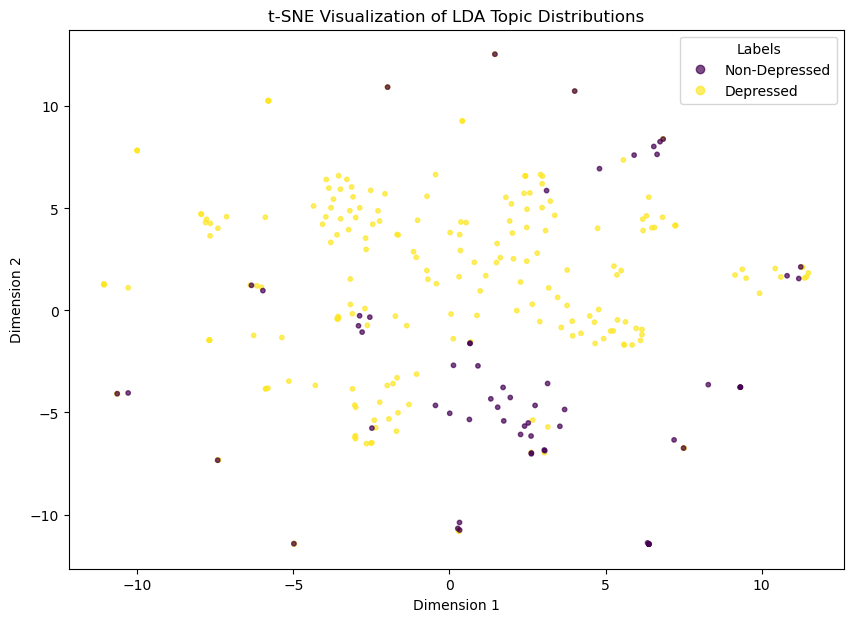

LDA pipeline complete.


In [134]:
lda_extractor = LDAFeatureExtractor(documents, labels)
lda_extractor.run_pipeline()

In [135]:
# Visualising depression
lda_extractor.visualize_lda(label_filter=1)

Generating LDA visualization for depressed posts...


In [136]:
# Visualising non-depression
lda_extractor.visualize_lda(label_filter=0)

Generating LDA visualization for non-depressed posts...


### Outcomes: 30 topics using LDA was appropriate instead of the 70 which the original paper found 